In [1]:
%matplotlib inline

# Lab2 - Active Learning on Streams

In this scenario we will look into stream based problems and implement an examplary active learning method for streams.

Stream assumptions:
- we are dealing with Big Data
- we cannot store or use all of the incoming data at once
- labeling process is expensive, we cannot pass all of the samples to be labeled
- as we cannot store the unncesesary objects we should decide which objects should be stored and labeld in real time

An example of data stream with images can found here: \
https://randomwordgenerator.com/picture.php


1. Simulate a stream dataset

In case we do not have an actual data stream available we can simulate one with a normal dataset.

Lets load a Fashion-MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml
X, Y = fetch_openml('Fashion-MNIST', return_X_y=True) 

We will simulate a small labeled initial training dataset by taking 10% of the data randomly.

 Shape of initial training dataset (70, 784)


(array([8., 5., 6., 9., 9., 4., 7., 9., 6., 7.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

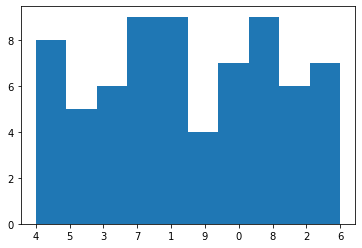

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_initial_train, X_stream,  Y_initial_train, Y_stream = train_test_split(X.values, Y, train_size=0.001, random_state=42)
print(f' Shape of initial training dataset {X_initial_train.shape}')
plt.hist(Y_initial_train)

Create a plotting function for a single image.

In [23]:
X.isna().sum().sum()

0

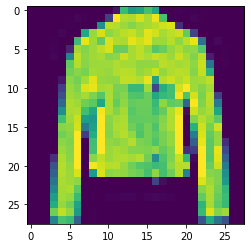

In [4]:
def plot_img(x):
    plt.imshow(x.reshape(28, 28))
    plt.show()

plot_img(X_initial_train[0])

Create a generator that return a random image from the X_stream and its index in the array.

41328 (784,)


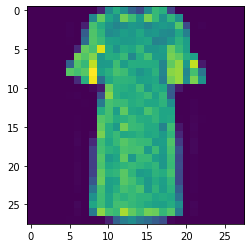

In [28]:
from itertools import islice
import numpy as np

def stream_data(X_stream):
    idx = np.random.randint(0, X_stream.shape[0])
    yield idx, X_stream[idx] 

for (_, x) in islice(stream_data(X_stream), 10):
    print(_, x.shape)
    plot_img(x)

2. Scale the data and train a ridge logistic regression model on the initial dataset.

In [69]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifier

from sklearn.preprocessing import StandardScaler

model1 = make_pipeline(StandardScaler(), RidgeClassifier())
model1.fit(X_initial_train, Y_initial_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgeclassifier', RidgeClassifier())])

3. Check the accuracy of the model on the initial training data.

In [70]:
accuracy1 = model1.score(X_initial_train, Y_initial_train)
accuracy1

1.0

In [71]:
model1.score(X_stream, Y_stream)

0.5618904618904619

Now we will try to create a different model from the version space.

4. Create another ridge logistic regression with other regularization parameters.
Try to obtain the same accuracy on inital training data with different coefficient.(exactly the same predictions on the training dataset would be perfect)

In [65]:
model2 = make_pipeline(StandardScaler(), RidgeClassifier(alpha=0.5))
model2.fit(X_initial_train, Y_initial_train)
accuracy2 = model2.score(X_initial_train, Y_initial_train)
accuracy2

1.0

In [66]:
model2.score(X_stream, Y_stream)

0.5614328614328614

5. Iterate through a stream data, predict class with both models. Are there objects on which their predictions differ? Plot few of such objects.

['1'] ['5']


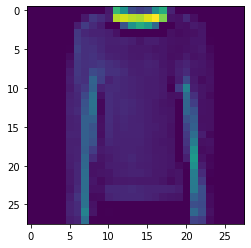

['4'] ['6']


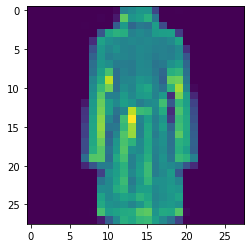

['4'] ['6']


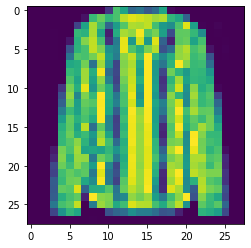

['0'] ['6']


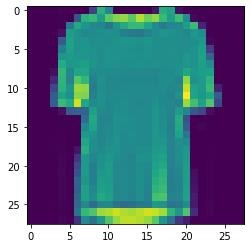

['0'] ['2']


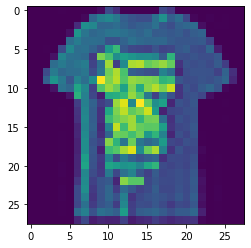

['0'] ['3']


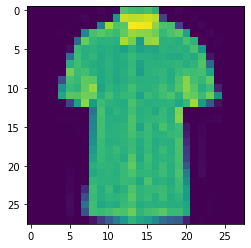

['3'] ['4']


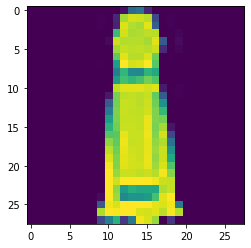

['5'] ['8']


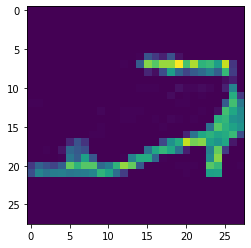

['5'] ['0']


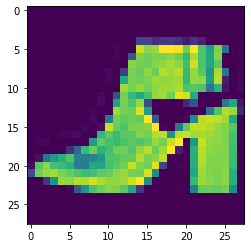

['0'] ['2']


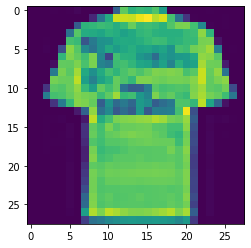

['4'] ['1']


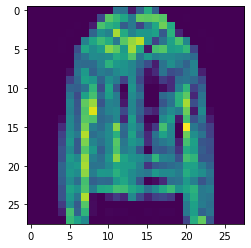

['1'] ['3']


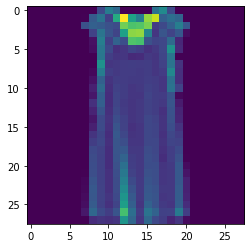

['9'] ['7']


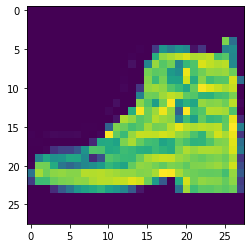

['3'] ['0']


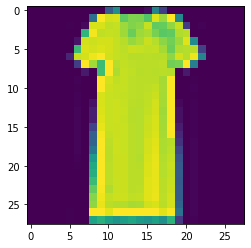

['0'] ['8']


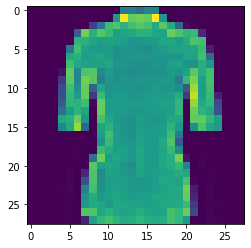

['9'] ['2']


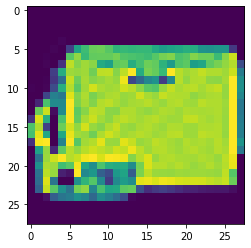

['2'] ['1']


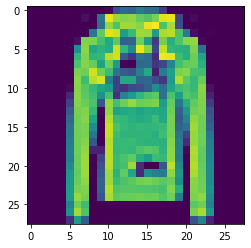

['4'] ['3']


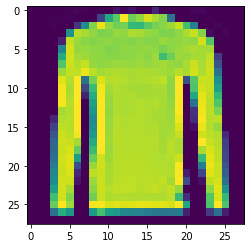

['8'] ['3']


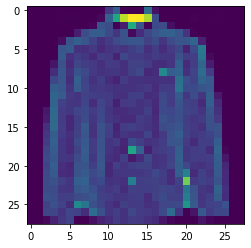

['2'] ['6']


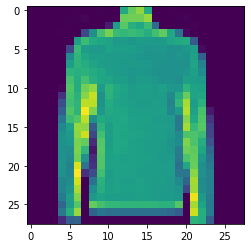

['3'] ['6']


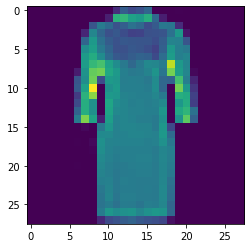

['0'] ['2']


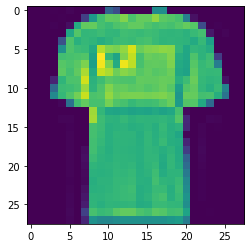

In [41]:
for x in islice(X_stream, 10000):
    y_pred1 = model1.predict(x[np.newaxis])
    y_pred2 = model2.predict(x[np.newaxis])
    if y_pred1 != y_pred2:
        print(y_pred1, y_pred2)
        plot_img(x)

We can use the same approach on the pool pased problem it is enough to rank the samples by model probability distribution difference across the prediction classes.

6.* Create a loop for retraining the models after choosing an object with different predictions.(Add such objects to training data, assuming that it was labelled)

In [84]:
import pandas as pd

In [91]:
model1 = make_pipeline(StandardScaler(), RidgeClassifier())
model1.fit(X_initial_train, Y_initial_train)
model2 = make_pipeline(StandardScaler(), RidgeClassifier(alpha=0.5))
model2.fit(X_initial_train, Y_initial_train)

X_initial_train_1 = X_initial_train.copy()
Y_initial_train_1 = Y_initial_train.copy()
df_runs = pd.DataFrame()
for i, (x_data, y_data) in enumerate(zip(X_stream, Y_stream)):
    y_pred1 = model1.predict(x_data[np.newaxis])
    y_pred2 = model2.predict(x_data[np.newaxis])
    if y_pred1 != y_pred2:
        df_runs = pd.concat([df_runs, pd.DataFrame({'y_pred1': y_pred1, 'y_pred2': y_pred2,
                                                    'y_data': y_data}, index=[i])], axis=0)
        X_initial_train_1 = np.concatenate([X_initial_train_1, [x_data]])
        Y_initial_train_1 = np.concatenate([Y_initial_train_1, [y_data]])
        model1.fit(X_initial_train_1, Y_initial_train_1)
        model2.fit(X_initial_train_1, Y_initial_train_1)
        

In [89]:
df_runs.T

,747,1038,1469,3064,3131,3232,4026,4481,5277,5544,...,28808,28848,29098,29281,29337,29598,29662,29719,29916,29934
y_pred1,1,2,0,0,5,4,8,4,2,6,...,8,6,4,2,2,3,8,9,8,4
y_pred2,5,4,6,2,6,6,2,3,4,2,...,0,2,2,6,6,2,6,4,2,0
y_data loss,2,4,6,3,5,6,8,3,2,2,...,6,6,4,6,2,4,8,9,5,3


In [92]:
print(model1.score(X_stream, Y_stream), model2.score(X_stream, Y_stream))

0.6838552838552838 0.6745602745602746


7. ** Create a third model from the same version space, use all 3 models in identification of informative samples.

How is this connected to evaluation process? How to estimate those models performance?

In [ ]:
model1 = make_pipeline(StandardScaler(), RidgeClassifier())
model1.fit(X_initial_train, Y_initial_train)
model2 = make_pipeline(StandardScaler(), RidgeClassifier(alpha=0.5))
model2.fit(X_initial_train, Y_initial_train)
model3 = make_pipeline(StandardScaler(), RidgeClassifier(alpha=2))
model3.fit(X_initial_train, Y_initial_train)

X_initial_train_1 = X_initial_train.copy()
Y_initial_train_1 = Y_initial_train.copy()
df_runs = pd.DataFrame()
for i, (x_data, y_data) in enumerate(zip(X_stream[:30000], Y_stream[:30000])):
    y_pred1 = model1.predict(x_data[np.newaxis])
    y_pred2 = model2.predict(x_data[np.newaxis])
    y_pred3 = model3.predict(x_data[np.newaxis])
    if y_pred1 != y_pred2 or y_pred2 != y_pred3 or y_pred1 != y_pred3:
        df_runs = pd.concat([df_runs, pd.DataFrame({'y_pred1': y_pred1, 'y_pred2': y_pred2, 'y_pred3': y_pred3,
                                                    'y_data': y_data}, index=[i])], axis=0)
        X_initial_train_1 = np.concatenate([X_initial_train_1, [x_data]])
        Y_initial_train_1 = np.concatenate([Y_initial_train_1, [y_data]])
        model1.fit(X_initial_train_1, Y_initial_train_1)
        model2.fit(X_initial_train_1, Y_initial_train_1)
        model3.fit(X_initial_train_1, Y_initial_train_1)
        